In [1]:
import os
from datetime import timedelta


from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import seaborn as sns
import sklearn.preprocessing

#### Load Streamflow Data

In [2]:
paper_proj_dir = "/Users/mcarb/Documents/uno/2022_spring/thesis/\
repositories/streamflow_forcasting/DailyStreamflowForecastAutoReg"
paper_data_dir = os.path.join(paper_proj_dir, "time_series")

yx_ts_fname = "YangXianDailyFlow1997-2014.xlsx"
zjs_ts_fname = "ZhangJiaShanDailyFlow1997-2014.xlsx"

yx_ts_path = os.path.join(paper_proj_dir, paper_data_dir, yx_ts_fname)
zjs_ts_path = os.path.join(paper_proj_dir, paper_data_dir, zjs_ts_fname)

uploaded = files.upload()

Saving YangXianDailyFlow1997-2014.xlsx to YangXianDailyFlow1997-2014 (1).xlsx
Saving YangXianRunoff1967-2014.xlsx to YangXianRunoff1967-2014 (1).xlsx
Saving ZhangJiaShanDailyFlow1997-2014.xlsx to ZhangJiaShanDailyFlow1997-2014 (1).xlsx
Saving ZhangJiaShanRunoff1967-2017.xlsx to ZhangJiaShanRunoff1967-2017 (1).xlsx


### Explore Dataset

In [3]:
df = pd.read_excel(os.path.join("/content", yx_ts_fname))
df = df.iloc[:,0:2] 
df = df.set_index('TM')

# Verify that the index step is daily.
assert df.rolling('2D').count()[1:].min()[0] == 2

In [4]:
df

,DailyFlow
TM,
1997-01-01,60.1
1997-01-02,59.9
1997-01-03,56.8
1997-01-04,51.0
1997-01-05,49.3
...,...
2014-12-27,66.4
2014-12-28,67.1
2014-12-29,63.5


In [5]:
df.dtypes

DailyFlow    float64
dtype: object

### Prepare Dataset

In [34]:
array = df.to_numpy(dtype=np.float32)

In [35]:
def split(array, percentages):
  array_len = len(array)
  
  train_len = int(array_len*.70)
  test_len = int(array_len*.20)
  
  train = array[:train_len]
  test = array[train_len : train_len+test_len]
  val = array[train_len+test_len:]
  
  return (train, test, val)

def scale(train, test, validation): 
  scaler = sklearn.preprocessing.MinMaxScaler()
  scaler.fit(train)
  
  train, test, validation = (
    scaler.transform(array) for array in (train, test, validation))

  return train, test, validation

In [36]:
train, test, val = split(array, (0.70, 0.20))

In [37]:
train, test, val = scale(train, test, val)

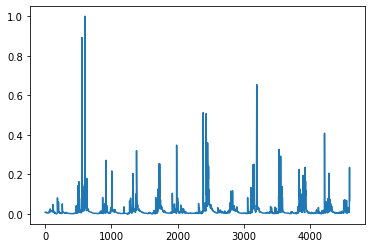

In [38]:
plt.plot(train.squeeze())

In [10]:
window_length = 11

train, test, val = (
  sliding_window_view(array.flatten(), window_length) 
  for array in (train, test, val))

In [11]:
def batch_windowed_array(windowed_array, batch_size, window_length):
  # Make length of windowed array divisible by the batch size
  array_dim_1, array_dim_2 = windowed_array.shape
  batches = int(array_dim_1/batch_size)
  batched_array_length = batch_size * batches
  windowed_array = windowed_array[:batched_array_length, :]
  print(f'Making {batches} batches.\n')

  batched_array = windowed_array.reshape(-1, batch_size, window_length)

  return batched_array

In [12]:
train, test, val = (batch_windowed_array(a, 50, 11) for a in (train, test, val))

Making 91 batches.

Making 26 batches.

Making 12 batches.



In [13]:
# Split datasets into features and labels. 
(X_train, Y_train), (X_test, Y_test), (X_val, Y_val) = (
  np.split(ary=a, indices_or_sections=[1], axis=2) for a in (train, test, val))

In [14]:
print(X_train.shape, ' ', Y_train.shape)

(91, 50, 1)   (91, 50, 10)


In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.plot()


### Prepare Model

In [15]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate


In [16]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [17]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 32)     96          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 64)     4160        ['conv1d[0][0]']                 
                                                                                                  
 gated_activation_unit (GatedAc  (None, None, 32)    0           ['conv1d_1[0][0]']               
 tivationUnit)                                                                                

In [20]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=.009), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=1000,
                    validation_data=(X_val, Y_val))

Epoch 1/1000
3/3 [==============================] - 2s 201ms/step - loss: 0.0085 - last_time_step_mse: 0.0091 - val_loss: 0.0083 - val_last_time_step_mse: 0.0074
Epoch 2/1000
3/3 [==============================] - 0s 35ms/step - loss: 0.0085 - last_time_step_mse: 0.0091 - val_loss: 0.0083 - val_last_time_step_mse: 0.0074
Epoch 3/1000
3/3 [==============================] - 0s 41ms/step - loss: 0.0085 - last_time_step_mse: 0.0091 - val_loss: 0.0082 - val_last_time_step_mse: 0.0074
Epoch 4/1000
3/3 [==============================] - 0s 37ms/step - loss: 0.0085 - last_time_step_mse: 0.0091 - val_loss: 0.0082 - val_last_time_step_mse: 0.0073
Epoch 5/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.0085 - last_time_step_mse: 0.0091 - val_loss: 0.0082 - val_last_time_step_mse: 0.0073
Epoch 6/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.0085 - last_time_step_mse: 0.0091 - val_loss: 0.0082 - val_last_time_step_mse: 0.0073
Epoch 7/1000
3/3 [===============

In [ ]:
type(train_ds)
for ds in train_ds.take(1):
  print(ds)

(<tf.Tensor: shape=(32, 50, 1), dtype=float32, numpy=
array([[[0.00865808],
        [0.00862547],
        [0.00812001],
        ...,
        [0.00557639],
        [0.00526659],
        [0.0052992 ]],

       [[0.00862547],
        [0.00812001],
        [0.0071743 ],
        ...,
        [0.00526659],
        [0.0052992 ],
        [0.00536442]],

       [[0.00812001],
        [0.0071743 ],
        [0.00689711],
        ...,
        [0.0052992 ],
        [0.00536442],
        [0.00500571]],

       ...,

       [[0.00583727],
        [0.00596771],
        [0.00600033],
        ...,
        [0.0208707 ],
        [0.01858797],
        [0.01679439]],

       [[0.00596771],
        [0.00600033],
        [0.00606555],
        ...,
        [0.01858797],
        [0.01679439],
        [0.01581608]],

       [[0.00600033],
        [0.00606555],
        [0.00642426],
        ...,
        [0.01679439],
        [0.01581608],
        [0.01532692]]], dtype=float32)>, <tf.Tensor: shape=(32, 50, 10), dt